In [2]:
import numpy as np
import areametric as am
from scipy.stats import wasserstein_distance
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

In [3]:
pallette = {'brattle.blue':   (0,70,127),
            'aqua':           (127,185,194),
            'orange':         (244,119,53),
            'citron.light':   (245,237,96),
            'olive.light':    (176,188,34),
            'red':            (239,70,35),
            'plum':           (102,4,96),
            'emerald':        (0,161,142),
            'citron':         (213,209,14),
            'olive':          (138,141,9)
    }

For one-dimensional normal distributions ($X \sim N(\mu_x, \sigma^2_x), Y \sim N(\mu_y, \sigma^2_y)$) the wasserstein distance is bounded by:
$$
\begin{align}
\overbrace{\lvert \mu_x - \mu_y \rvert}^{W^{LB}(X,Y)} \leq \underbrace{\int_0^1\lvert F^{-1}_1(q)- F^{-1}_2(q)\rvert dq}_{W(X,Y)} \leq \overbrace{\lvert \mu_x - \mu_y \rvert + \lvert \sigma_x - \sigma_y \rvert}^{W^{UB}(X,Y)}
\end{align}
$$

The mean absolute error ($U(X,Y)$) between normally distributed data can be characterised as a folded normal with the following mean:
$$
\begin{align}
U(X,Y) = \mathbb{E} \lvert X - Y \rvert = \sigma_z \sqrt{\frac{2}{\pi}} \exp{\left(\frac{-\mu_z}{\sigma_z}\right) + \mu_z \left[ 1- 2 \Phi\left(\frac{-\mu_z}{\sigma_z}\right) \right]}
\end{align}
$$
where $Z = \lvert X-Y \rvert$ with $\mu_z = \mu_x - \mu_y$ and $\sigma_z = \sqrt{\sigma^2_x + \sigma^2_y}$

In [4]:
# folded normal https://en.wikipedia.org/wiki/Folded_normal_distribution
from scipy.stats import norm
def fn_mean(μ, σ):
    return σ*np.sqrt(2/np.pi)*np.exp(-μ**2/(2*σ**2)) + μ*(1-2*norm.cdf(-μ/σ))

def calc_W_LB(μ_a,μ_b,σ_a,σ_b):
    return np.abs(μ_a-μ_b)

def calc_W_UB(μ_a,μ_b,σ_a,σ_b):
    return np.abs(μ_a-μ_b) + np.abs(σ_a-σ_b)
    
np.random.seed(0)
N_r = 100 # number of simulations
N_s = 10000 # number of samples
μ_y = 10
σ_y = 10

μ_range = np.arange(0,20,1)
σ_range = np.arange(1,20,1)
MAE = np.zeros((len(μ_range),len(σ_range),N_r))
W = np.zeros_like(MAE)

W_UB = np.zeros((len(μ_range),len(σ_range)))
W_LB = np.zeros_like(W_UB)
MAE_FN = np.zeros_like(W_UB)
MAE_UB = np.zeros_like(W_UB)
MAE_LB = np.zeros_like(W_UB)

for i,μ_x in tqdm(enumerate(μ_range)):
    for j,σ_x in enumerate(σ_range):
        MAE_FN[i,j] = fn_mean(μ_x-μ_y,np.sqrt(σ_x**2+σ_y**2))
        W_UB[i,j] = calc_W_UB(μ_x,μ_y,σ_x,σ_y)
        W_LB[i,j] = calc_W_LB(μ_x,μ_y,σ_x,σ_y)
        for k in range(N_r):
            μ = np.array([μ_x,μ_y])
            Σ = np.array([σ_x**2,σ_y**2])*np.identity(2)
            X = np.random.multivariate_normal(μ,Σ,N_s)
            MAE[i,j,k] = mean_absolute_error(X[:,0], X[:,1])
            W[i,j,k] = wasserstein_distance(X[:,0], X[:,1])

0it [00:00, ?it/s]

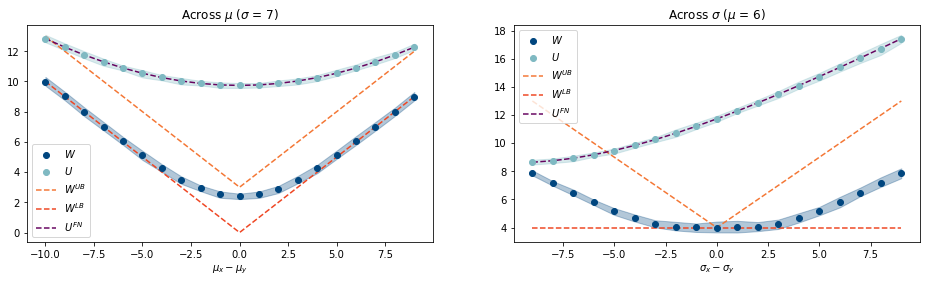

In [5]:
fig, axes = plt.subplots(1,2, figsize = (16,4))
cpal = [tuple([x[0]/255,x[1]/255,x[2]/255]) for x in list(pallette.values())]

x = μ_range-μ_y
j = 6
axes[0].set_title("Across $\mu$ ($\sigma$ = {})".format(σ_range[j]))
axes[0].fill_between(x, W[:,j].min(axis=1),W[:,j].max(axis=1), alpha = 0.3, color= cpal[0], zorder = 0)
axes[0].fill_between(x, MAE[:,j].min(axis=1),MAE[:,j].max(axis=1), alpha = 0.3, color = cpal[1],zorder = 0)
axes[0].scatter(x, W[:,j].mean(axis=1),label = "$W$", color = cpal[0],  zorder = 10)
axes[0].scatter(x, MAE[:,j].mean(axis=1), label = "$U$", color = cpal[1], zorder = 10)
axes[0].plot(x,W_UB[:,j], label = "$W^{UB}$", ls = '--', color = cpal[2], zorder = 5)
axes[0].plot(x,W_LB[:,j], label = "$W^{LB}$", ls = '--', color = cpal[5],zorder = 5)
axes[0].plot(x,MAE_FN[:,j], label = "$U^{FN}$", ls = '--', color = cpal[6], zorder = 5)
axes[0].set_xlabel("$\mu_x - \mu_y$")
axes[0].legend()

x = σ_range-σ_y
i = 6
axes[1].set_title("Across $\sigma$ ($\mu$ = {})".format(μ_range[i]))
axes[1].fill_between(x, W[i,:].min(axis=1),W[i,:].max(axis=1), alpha = 0.3, color= cpal[0], zorder = 0)
axes[1].fill_between(x, MAE[i,:].min(axis=1),MAE[i,:].max(axis=1), alpha = 0.3, color= cpal[1], zorder = 0)
axes[1].scatter(x, W[i,:].mean(axis=1), label = "$W$", color = cpal[0], zorder = 10)
axes[1].scatter(x, MAE[i,:].mean(axis=1), label = "$U$", color = cpal[1], zorder = 10)
axes[1].plot(x,W_UB[i,:], label = "$W^{UB}$",ls = '--', color = cpal[2], zorder = 5)
axes[1].plot(x,W_LB[i,:], label = "$W^{LB}$",ls = '--', color = cpal[5],zorder = 5)
axes[1].plot(x,MAE_FN[i,:], label = "$U^{FN}$",ls = '--', color = cpal[6], zorder = 5)
axes[1].set_xlabel("$\sigma_x - \sigma_y$")
axes[1].legend()

(-1.0, 1.0)

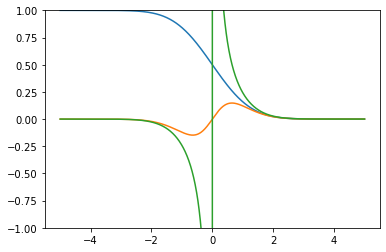

In [56]:
fig, axes = plt.subplots(1,1)
x = np.linspace(-5,5,1000)
axes.plot(x,1-norm.cdf(x))
axes.plot(x,(1/np.sqrt(2*np.pi)*(x/(x**2+1))*np.exp(-x**2/2)))
axes.plot(x,(1/np.sqrt(2*np.pi)*(1/x)*np.exp(-x**2/2)))
axes.set_ylim([-1,1])

In [9]:
μ_x = μ_range[0]
μ_y = μ_range[0]
σ_x = 2
σ_y = 1
print(fn_mean(μ_x-μ_y,np.sqrt(σ_x**2+σ_y**2)))
mean_absolute_error(np.random.normal(μ_x,σ_x,N_s),np.random.normal(μ_y,σ_y,N_s))

1.7841241161527712


1.7953149948674076

In [384]:
MAE_FN[0,:]

array([11.69050628, 11.7630853 , 11.88394838, 12.05275327, 12.2687371 ,
       12.53059675, 12.83646531, 13.18398077, 13.57041504, 13.99282457,
       14.44819235, 14.93354395, 15.4460317 , 15.98298891, 16.54195927,
       17.12070766, 17.7172183 , 18.32968464, 18.9564947 ])

In [369]:
from scipy import integrate
μ_x = 0
μ_y = 0
σ_x = 2
σ_y = 1

norm_cdf = lambda x,mu,sig: norm.cdf(x, loc = mu , scale = sig)
cdf1 = integrate.quad(norm_cdf, -np.inf, μ_x, args=(μ_x,σ_x))[0]*2
cdf2 = integrate.quad(norm_cdf, -np.inf, μ_y, args=(μ_y,σ_y))[0]*2
print("CDF: %.2f" %np.abs(cdf1-cdf2))

norm_ppf = lambda x,mu,sig: np.abs(norm.ppf(x, loc = mu , scale = sig))
ppf1 = integrate.quad(norm_ppf, 0, 1, args=(μ_x,σ_x))[0]
ppf2 = integrate.quad(norm_ppf, 0, 1, args=(μ_y,σ_y))[0]
print("PPF: %.2f" %np.abs(ppf1-ppf2))

N = 10000
R = 100
E_W = 0
for r in range(R):
    E_W += wasserstein_distance(np.random.normal(μ_x,σ_x,N),np.random.normal(μ_y,σ_y,N))
print("W: %.2f" %(E_W/R))

C_W = np.abs(μ_x - μ_y) + np.abs(σ_x- σ_y)*np.sqrt(2/np.pi)
print("Closed: %.2f" % C_W)

CDF: 0.80
PPF: 0.80
W: 0.80
Closed: 0.80


In [366]:
np.abs(μ_x - μ_y) + (σ_x- σ_y)*np.sqrt(2/np.pi)

5.595769121605731

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:xlabel='x, y', ylabel='Probability'>)

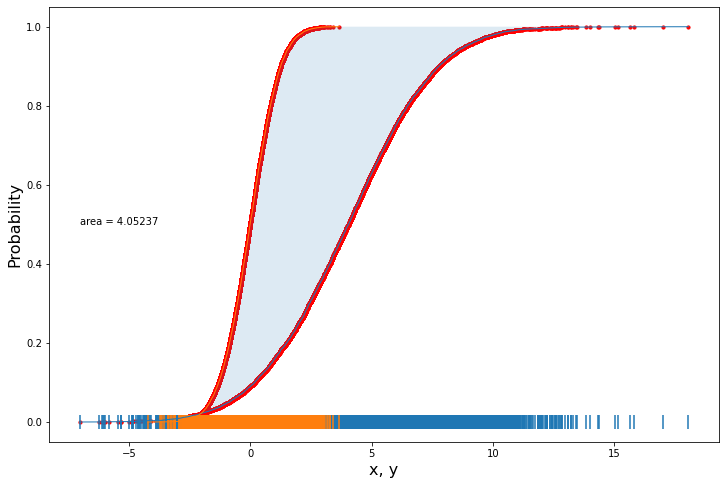

In [363]:
am.plot_area(np.random.normal(μ_x,σ_x,N),np.random.normal(μ_y,σ_y,N))

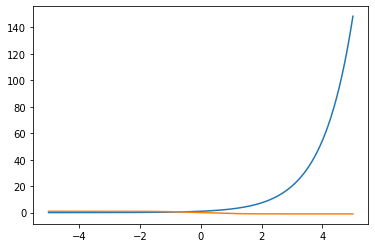

In [375]:
x = np.linspace(-5,5, 1000)
y1 = np.exp(x)
y2 = 1-2*norm.cdf(x)
plt.plot(x,y1)
plt.plot(x,y2)
# plt.set_ylim([0,2])